SARIMA (Seasonal AutoRegressive Integrated Moving Average) for predicting IBM stock closing prices, along with ACF/PACF analysis and model selection using AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).

In [3]:
pip install pandas statsmodels matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

In [5]:
# Ignoring warnings
warnings.filterwarnings("ignore")

In [6]:
# Loading the IBM dataset
df = pd.read_csv('IBM2017.csv')

In [7]:
# Converting 'Date' column to datetime format and sorting by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

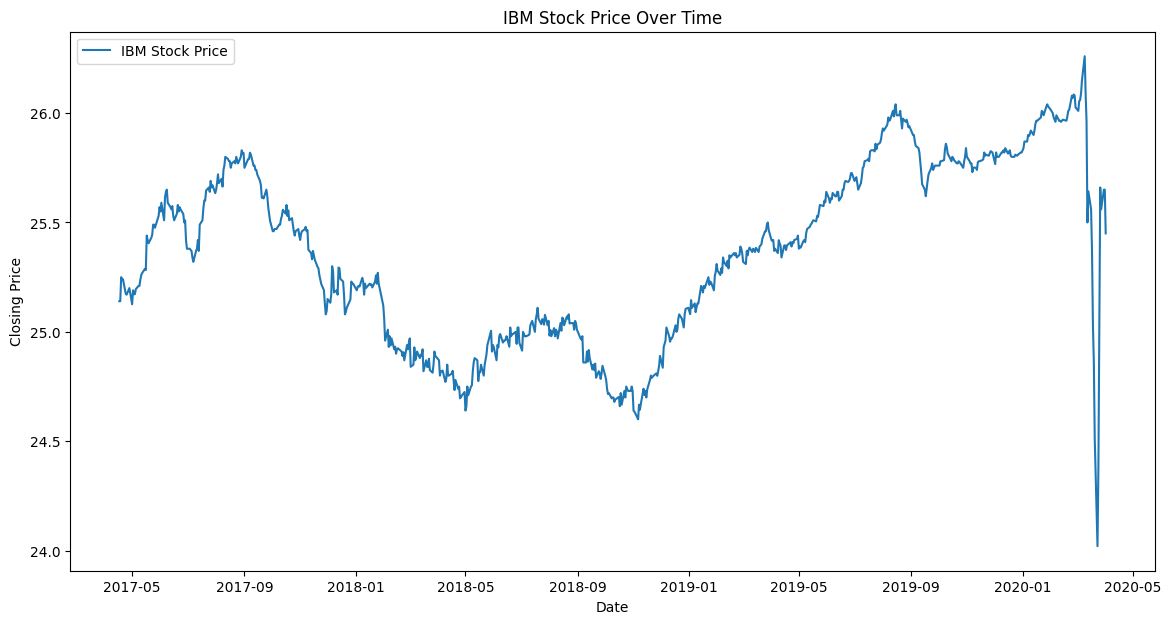

In [8]:
# Plotting the original data
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='IBM Stock Price')
plt.title('IBM Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [9]:
# Differencing to remove trend and achieve stationarity
df['Close_diff'] = df['Close'].diff().dropna()

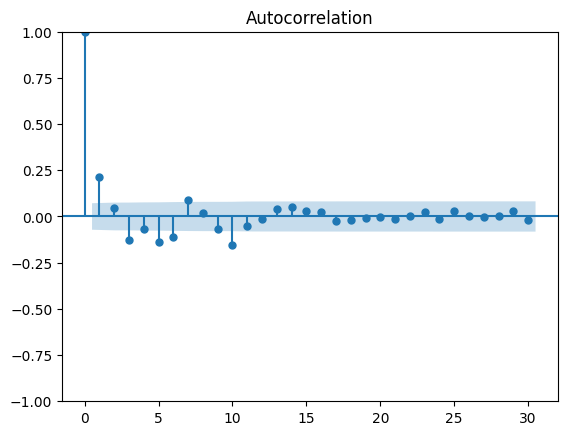

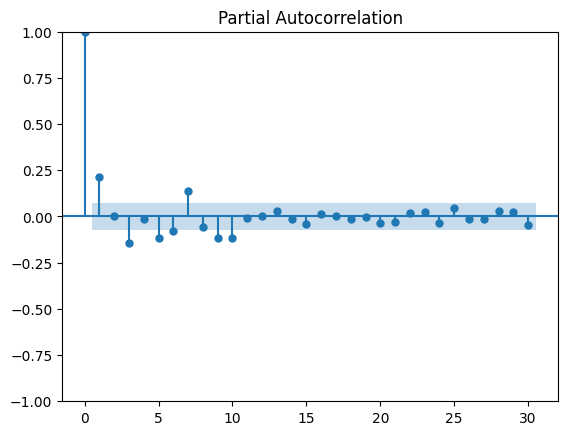

In [10]:
# Plotting ACF and PACF
plot_acf(df['Close_diff'].dropna(), lags=30)
plot_pacf(df['Close_diff'].dropna(), lags=30)
plt.show()

In [11]:
# Function to fit SARIMA and return AIC/BIC
def sarima_grid_search(y, pdq, seasonal_pdq, s):
    results = []
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(y, 
                                order=param, 
                                seasonal_order=seasonal_param + (s,),
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                results.append([param, seasonal_param, model_fit.aic, model_fit.bic])
            except:
                continue
    return pd.DataFrame(results, columns=['pdq', 'seasonal_pdq', 'AIC', 'BIC'])

In [12]:
# Setting the p, d, q and seasonal P, D, Q ranges based on ACF and PACF
p = d = q = range(0, 3)
seasonal_pdq = [(x, y, z) for x in range(0, 2) for y in range(0, 2) for z in range(0, 2)]
pdq = [(x, y, z) for x in p for y in d for z in q]

In [13]:
# Performing grid search to find the best SARIMA model based on AIC and BIC
seasonal_period = 12  # Adjust this to match the seasonal frequency of your data
grid_search_results = sarima_grid_search(df['Close'], pdq, seasonal_pdq, seasonal_period)

In [14]:
# Displaying the top 5 models ranked by AIC
print(grid_search_results.sort_values(by='AIC').head())

           pdq seasonal_pdq          AIC          BIC
184  (2, 1, 2)    (0, 0, 0) -2099.893750 -2076.847004
112  (1, 1, 2)    (0, 0, 0) -2093.188090 -2074.750693
96   (1, 1, 0)    (0, 0, 0) -2088.054250 -2078.830168
88   (1, 0, 2)    (0, 0, 0) -2086.912232 -2068.469448
40   (0, 1, 2)    (0, 0, 0) -2086.664835 -2072.836787


In [16]:
# Selecting the best model
best_model_params = grid_search_results.sort_values(by='AIC').iloc[0]
print(f'Best Model: SARIMA{best_model_params["pdq"]}x{best_model_params["seasonal_pdq"] + (seasonal_period,)}')


Best Model: SARIMA(2, 1, 2)x(0, 0, 0, 12)


In [17]:
# Fitting the best SARIMA model
model = SARIMAX(df['Close'], 
                order=best_model_params['pdq'], 
                seasonal_order=best_model_params['seasonal_pdq'] + (seasonal_period,),
                enforce_stationarity=False, 
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

In [18]:
# Making predictions
df['Prediction'] = model_fit.fittedvalues

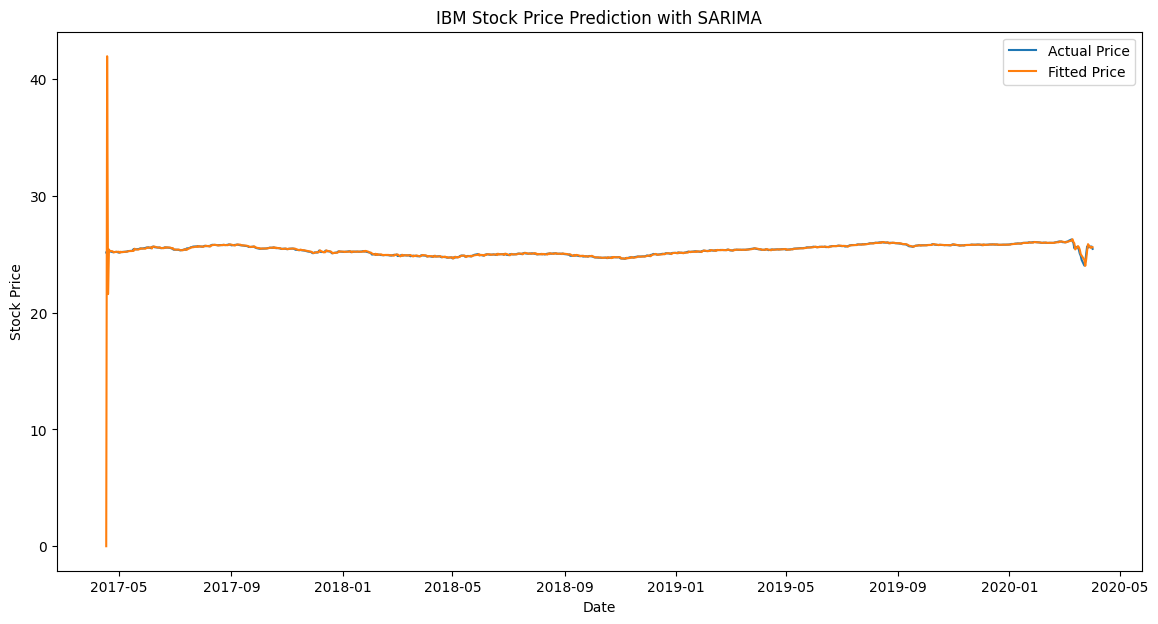

In [19]:
# Plotting the actual vs fitted prices
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Actual Price')
plt.plot(df['Date'], df['Prediction'], label='Fitted Price')
plt.title('IBM Stock Price Prediction with SARIMA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
# Forecasting future stock prices
future_steps = 12
forecast = model_fit.get_forecast(steps=future_steps)
forecast_index = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps+1, freq='M')[1:]


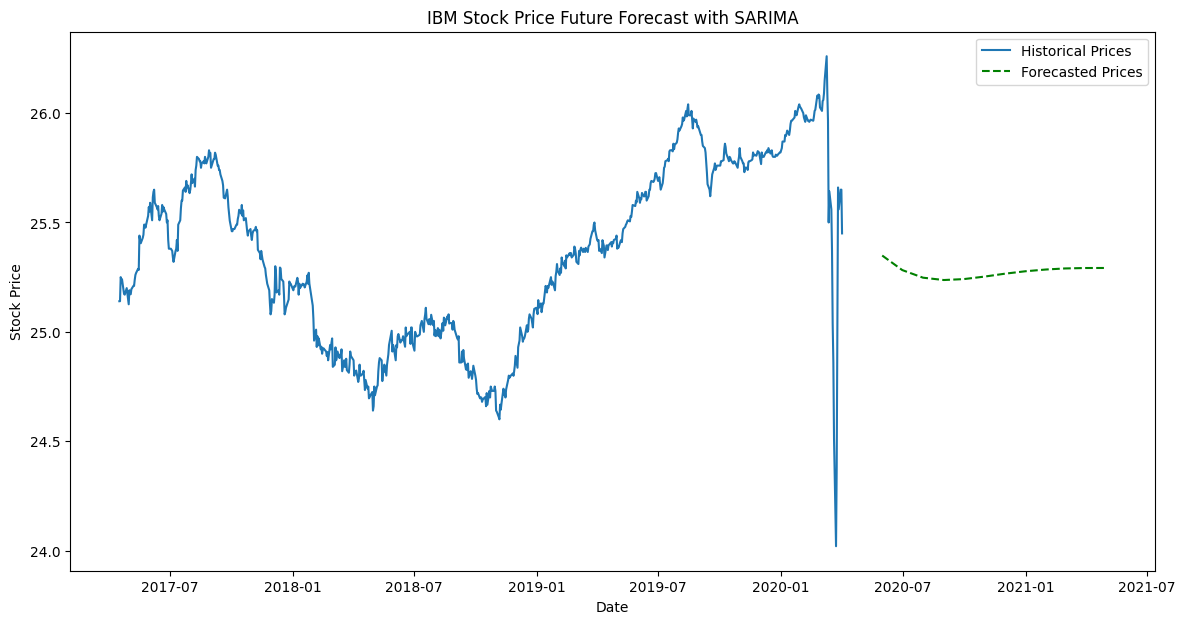

In [21]:
# Plotting the future forecast
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Historical Prices')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Prices', color='green', linestyle='--')
plt.title('IBM Stock Price Future Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d6ccbe74-5722-4f84-8e54-7da9a834c88a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>